# Análise de Sensibilidade
Este tipo de análise se propõe a medir a influencia de cada parâmetro do modelo sobre o resultado da simulação. A Sensibilidade do modelo à cada parâmetros é representada por um valor numérico chamado de *índice de sensibilidade*. estes índices pode ser de vários tipos:
* **Indices de primeira ordem** medem a contribuição de cada parâmetro individualmente para a variância da saída do modelo.
* **Indices de segunda ordem**  medem a contribuição de pares de parâmetros para a variância da saída do modelo.
* **Indices de ordem total** medem a contribuição de cada parâmetro incluindo todas as suas interações para a variância da saída do modelo.

Para realizarmos esta análise vamos precisar instalar duas bibliotecas: [salib](https://salib.readthedocs.io/en/latest/) e [epimodels](https://github.com/fccoelho/epimodels). Para instalá-los, basta ativar a shell do Sage:
```bash
sage -sh
```
e executar os seguintes comandos:
```
pip install salib
pip install epimodels
```



In [1]:
%display typeset

In [107]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from epimodels.continuous import models as cm
import numpy as np
import pandas as pd
import pylab as plt

In [7]:
my_model = cm.SEQIAHR()

In [11]:
my_model.parameters

OrderedDict([('chi', '$\\chi'), ('phi', '$\\phi$'), ('beta', '$\\beta$'), ('rho', '$\\rho$'), ('delta', '$\\delta$'), ('gamma', '$\\gamma$'), ('alpha', '$\\alpha$'), ('mu', '$\\mu$'), ('p', '$p$'), ('q', '$q$'), ('r', '$r$')])

In [14]:
params = {
'chi': .3,
'phi': 0.012413633926076584,
'beta': 0.27272459855759813,
'rho': 0.2190519831830368,
'delta': 0.04168480042146949,
'gamma': 0.04,
'alpha':  0.3413355572047603,
'mu': 0.02359234606623134,
'p': 0.7693029079871165,
'q': 50,
'r': 55,
}
inits = [.99, 0, 1e-4, 0, 0, 0, 0, 0]

In [113]:
%%timeit
# parms = dict(zip(params.keys(),param_values[3]))
my_model(inits=inits, trange = [0,200], totpop=1, params=params)
# max(my_model.traces['I'])

10 loops, best of 5: 21.3 ms per loop


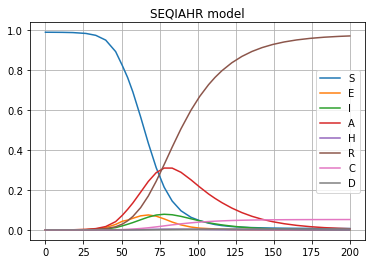

In [115]:
my_model.plot_traces()

## Definindo a análise

In [101]:
problem = {
    'num_vars': 11,
    'names': list(params.keys()),
    'bounds': [[0,.3],[0,1.],[0.1,2],[0.2,1],[0.01,1],[0.01,1],
              [0.01,1],[0.01,.7],[0.01,.7],[1,30],[1,12]]
}

## Gerando as amostras

In [116]:
param_values = saltelli.sample(problem, 1000)

In [117]:
param_values.shape

(24000, 11)

## Rodando o Modelo
Para fazer a análise de sensibilidade precisamos selecionar um aspecto da saída do model, sobre o qual desejamos estudar a variância em resposta à varância dos parâmetros. Para este caso simples, vamos escolher o valor de pico de $I(t)$.

In [118]:
def eval_model(parametros):
    parms = dict(zip(params.keys(),parametros))
    mod = cm.SEQIAHR()
    mod(inits=inits, trange = [0,200], totpop=1, params=parms)
    Y = max(mod.traces['I'])
    return Y

Agora, basta executar uma simulação para cada conjunto de valores de parâmetros que amostramos.

In [119]:
# Y = np.zeros([param_values.shape[0]])
# for i, p in enumerate(param_values):
#     Y[i] = eval_model(p)

Para acelerar a execução dos cenários, vamos paralelizar a simulação do modelo

In [120]:
from multiprocessing import Pool

In [121]:
Po = Pool()
Y = Po.map(eval_model, param_values)

In [122]:
Po.close()

In [123]:
Si = sobol.analyze(problem, np.array(Y), print_to_console=False)

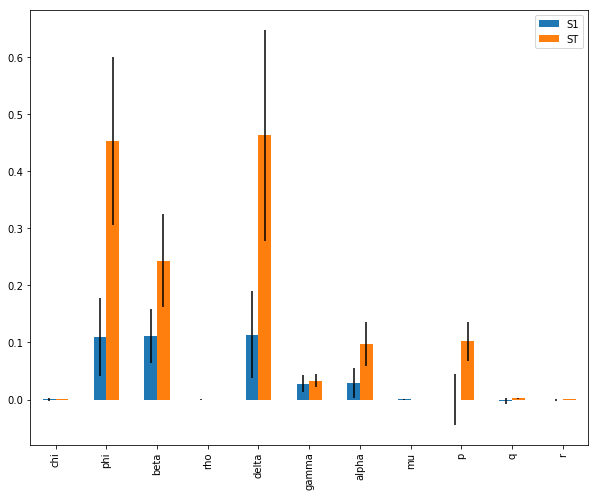

In [124]:
def plot_sobol(si,prob, order=1):
    Si_filter = {k:si[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(Si_filter, index=problem['names'][:-1])
    fig, ax = plt.subplots(1, figsize=(10,8))

    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]

    indices.plot.bar(yerr=err.values.T,ax=ax)
plot_sobol(Si,problem)

In [103]:
Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'][:-1])

In [104]:
Si_df

ST   ST_conf        S1   S1_conf
chi    0.000383  0.000865 -0.006220  0.012845
phi    0.371523  0.437696  0.008237  0.165755
beta   0.129016  0.270576  0.041395  0.101191
rho    0.000024  0.000027 -0.001125  0.002360
delta  0.405545  0.534001  0.097103  0.197571
gamma  0.019654  0.032977  0.030440  0.047838
alpha  0.039358  0.073779  0.040417  0.087603
mu     0.000003  0.000007 -0.000017  0.000366
p      0.097567  0.109621 -0.021822  0.079818
q      0.000595  0.000893 -0.004357  0.010404
r      0.000339  0.000798 -0.001447  0.004896

In [127]:
Si['S2_conf'].shape

(11, 11)